In [25]:
import os
import pandas as pd
from PIL import Image
import itertools
import random
from sklearn.utils import shuffle
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import torch
from torchvision.models import resnet18
from torchvision.models import resnet34
from torch.optim import Adam
from torch.utils.data import Subset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt

metadata_path = "drive/MyDrive/train_data.csv"
metadata = pd.read_csv(metadata_path)
test_data_path="drive/MyDrive/Test_data.csv"
test_data = pd.read_csv(test_data_path)
train_dir="drive/MyDrive/Colab Notebooks/MyTrain"
test_dir="drive/MyDrive/newimg/myTest"

model_path = "drive/MyDrive/model.pth"

def random_split(dataset, train_ratio=0.8, shuffle=True, random_seed=None):
    if random_seed is not None:
        random.seed(random_seed)
    indices = list(range(len(dataset)))
    if shuffle:
        random.shuffle(indices)
    split = int(train_ratio * len(dataset))
    train_indices = indices[:split]
    val_indices = indices[split:]
    return train_indices, val_indices




class LyricsDataset(Dataset):
    def __init__(self, filename, train_dir, img_path):
        self.data = filename
        self.num_of_labels = len(self.unique_labels())
        self.labels = self.enumerate_labels()
        self.artists_list = list(self.labels.keys())
        self.norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()
        self.train_dir = train_dir
        if img_path != "new_filename":
          self.small_data_set()
        self.img_path = img_path


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img1_path = self.data.iloc[idx][self.img_path]
        artistAnchor = self.data.iloc[idx]['artist']

        different_artist = random.choice(list(self.labels.keys()))
        while different_artist == artistAnchor:
            different_artist = random.choice(list(self.labels.keys()))
        negative = random.choice(self.data[self.data['artist'] == different_artist][self.img_path].values)

        positive = img1_path
        while positive == img1_path:
            positive = random.choice(self.data[self.data['artist'] == artistAnchor][self.img_path].values)

        anchor = Image.open(os.path.join(self.train_dir, img1_path))
        negative = Image.open(os.path.join(self.train_dir, negative))
        positive = Image.open(os.path.join(self.train_dir, positive))

        anchor = np.array(self.norm(self.to_tensor(anchor)))
        negative = np.array(self.norm(self.to_tensor(negative)))
        positive = np.array(self.norm(self.to_tensor(positive)))

        return anchor, positive, negative

    def enumerate_labels(self):
        c = 0
        d = {}
        labels = self.unique_labels()
        for artist_name in labels:
            d[artist_name] = c
            c += 1
        return d

    def unique_labels(self):
        labels = self.data['artist'].dropna().tolist()
        return set(labels)

    def print_stats(self):
        print("#######################")
        print("dataset name: ", self.name)
        print("dataset length: ", len(self.data))
        print("number of labels: ", len(self.unique_labels()))
        print("number of words in all lyrics: ", sum(len(x) for x in self.data['text'].to_list()))
        print("#######################")
    def small_data_set(self):
      labels = self.data['artist'].dropna().tolist()
      hist = {}
      m=[]
      for label in labels:
          if label in hist:
              hist[label] += 1
          else:
              hist[label] = 1

      labels = []
      for label, count in hist.items():
          if count >= 3:
              labels.append(label)

      def filter_rows(group):
          return group.head(3)

      self.data = self.data[self.data['artist'].isin(labels)].groupby('artist', group_keys=False).apply(filter_rows).head(5000)



class EnhancedSiameseNetwork(nn.Module):
    def __init__(self):
        super(EnhancedSiameseNetwork, self).__init__()
        # Use ResNet18 as the backbone
        self.backbone = models.resnet18(pretrained=True)
        self.backbone.fc = nn.Sequential(
            nn.Linear(self.backbone.fc.in_features, 512),
            nn.Linear(512, 256)  # Change the output size to 256
        )

    def forward_once(self, x):
        # Forward pass for one branch of the Siamese network
        return self.backbone(x)

    def forward(self, input1, input2, input3):

        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        output3 = self.forward_once(input3)
        return output1, output2, output3


class TripletLoss(torch.nn.Module):
    def __init__(self, margin=5.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = F.pairwise_distance(anchor, positive, keepdim=True)
        distance_negative = F.pairwise_distance(anchor, negative, keepdim=True)
        loss = torch.mean(torch.clamp(distance_positive - distance_negative + self.margin, min=0.0))
        return loss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model instantiation with the enhanced model
model = EnhancedSiameseNetwork().to(device)
criterion = TripletLoss()
optimizer = Adam(model.parameters(), lr=0.00001)
scheduler = StepLR(optimizer, step_size=20, gamma=0.1)

# DataLoaders

train_dataset = LyricsDataset(metadata, train_dir, 'filename')
test_dataset = LyricsDataset(test_data, test_dir, 'new_filename')

train_indices, val_indices = random_split(train_dataset, train_ratio=0.8, random_seed=42)

    # Create DataLoader for training subset
train_subset = Subset(train_dataset, train_indices)
train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)

    # Create DataLoader for validation subset
val_subset = Subset(train_dataset, val_indices)
val_loader = DataLoader(val_subset, batch_size=128, shuffle=False)

# train_dataset = SiameseNetworkDataset(train_pairs, train_labels, train_dir)
# test_dataset = SiameseNetworkDataset(test_pairs, test_labels, test_dir)

#train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

# for i,j,g in train_loader:
#   pass
# for i,j,g in test_loader:
#   pass

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10
Training Loss: 4.2126, Training Accuracy: 0.7643
Val Loss: 3.8785, Val Accuracy: 0.7981
Epoch 2/10
Training Loss: 3.6280, Training Accuracy: 0.7987
Val Loss: 3.1230, Val Accuracy: 0.8128
Epoch 3/10
Training Loss: 2.8330, Training Accuracy: 0.8314
Val Loss: 2.5311, Val Accuracy: 0.8370
Epoch 4/10
Training Loss: 2.4181, Training Accuracy: 0.8287
Val Loss: 2.3463, Val Accuracy: 0.8339
Epoch 5/10
Training Loss: 2.1301, Training Accuracy: 0.8498
Val Loss: 2.1164, Val Accuracy: 0.8370
Epoch 6/10
Training Loss: 2.0027, Training Accuracy: 0.8537
Val Loss: 2.0283, Val Accuracy: 0.8486
Epoch 7/10
Training Loss: 1.8890, Training Accuracy: 0.8627
Val Loss: 1.9553, Val Accuracy: 0.8486
Epoch 8/10
Training Loss: 1.7281, Training Accuracy: 0.8787
Val Loss: 1.7962, Val Accuracy: 0.8675
Epoch 9/10
Training Loss: 1.6146, Training Accuracy: 0.8837
Val Loss: 1.8723, Val Accuracy: 0.8580
Epoch 10/10
Training Loss: 1.4776, Training Accuracy: 0.8911
Val Loss: 1.7076, Val Accuracy: 0.8717
Test Accu

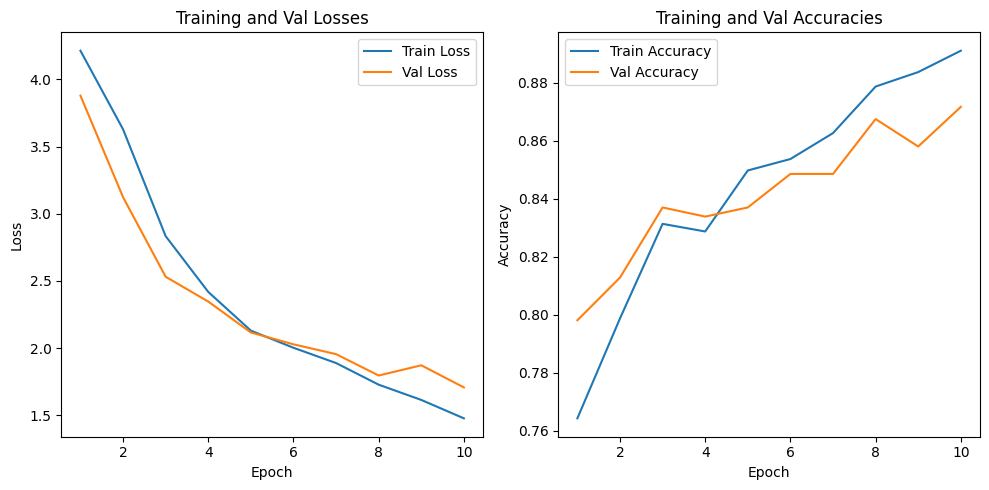

In [26]:


def train_epoch(model, device, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for img1, img2, img3 in train_loader:
        img1, img2, img3 = img1.float().to(device), img2.float().to(device), img3.float().to(device)
        optimizer.zero_grad()
        output1, output2, output3 = model(img1, img2, img3)
        loss = criterion(output1, output2, output3)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Compute training accuracy
        positive = F.pairwise_distance(output1, output2, keepdim=True)
        negative = F.pairwise_distance(output1, output3, keepdim=True)
        predictions = positive < negative
        labels = torch.ones_like(predictions).bool()
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total
    print(f"Training Loss: {avg_loss:.4f}, Training Accuracy: {accuracy:.4f}")
    return avg_loss, accuracy

def evaluate_model(model, device, test_loader, criterion, num):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for img1, img2, img3 in test_loader:
            img1, img2, img3 = img1.float().to(device), img2.float().to(device), img3.float().to(device)
            output1, output2, output3 = model(img1, img2, img3)
            test_loss += criterion(output1, output2, output3).item()
            positive = F.pairwise_distance(output1, output2, keepdim=True)
            negative = F.pairwise_distance(output1, output3, keepdim=True)
            predictions = positive < negative
            labels = torch.ones_like(predictions).bool()
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    test_loss /= len(test_loader)
    accuracy = correct / total
    if num==0:
      print(f"Val Loss: {test_loss:.4f}, Val Accuracy: {accuracy:.4f}")
    else:
      print(f"Test Accuracy: {accuracy:.4f}")
    return test_loss, accuracy

# Main Training and Testing Loop
epochs = 10
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    train_loss, train_accuracy = train_epoch(model, device, train_loader, criterion, optimizer)
    test_loss, test_accuracy = evaluate_model(model, device, val_loader, criterion,0)
    scheduler.step()

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)


num1,num2 = evaluate_model(model, device, test_loader, criterion,1)

# Plotting
plt.figure(figsize=(10, 5))

# Plotting training and test losses
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Val Losses')
plt.legend()

# Plotting training and test accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), test_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Val Accuracies')
plt.legend()

plt.tight_layout()
plt.show()

torch.save(model.state_dict(), model_path)
